In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

Load model

In [3]:
model = load_model("lstm.keras")

Load Tokenizer

In [6]:
with open("tokenizer.pkl", "rb") as handle:
    tokenizer = pickle.load(handle)

Load test data

In [10]:
df_test = pd.read_csv("../../../data/test_data.csv")

print("Length of test data:", len(df_test))
print(df_test.head())

Length of test data: 1938
        id                                               text  \
0  gg5ic5k  Thank you for sharing I have too many looming ...   
1  ghsx6oa  Alex Jones infowars.comSaid it will make you i...   
2  gidm2by  My dizziness this second time around hasn't be...   
3  gwe8ih0                       Yay!!! Thank you for sharing   
4  gr3f1r6  Thank you for your words! I hope I can get bet...   

               author                created_utc  No_of_comments  \
0        honeycombB82  2020-12-17 16:14:54+00:00             NaN   
1        StandupGamer  2021-01-02 05:52:26+00:00             NaN   
2              mjfx28  2021-01-07 02:13:41+00:00             NaN   
3            Rachet83  2021-04-30 06:18:38+00:00             NaN   
4  itsactuallynotokay  2021-03-16 05:35:11+00:00             NaN   

   Subjectivity  Polarity  Analysis   Parent    Link  
0      0.350000  0.237500  Positive   keq6mr  keq6mr  
1      0.000000  0.000000   Neutral   kof5pv  kof5pv  
2      0.

Preprocess the test data

In [11]:
X_test = tokenizer.texts_to_sequences(df_test["text"].astype(str))
max_len = 100  # Use the same max_len used during training
X_test = pad_sequences(X_test, maxlen=max_len)

In [12]:
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(df_test["Analysis"])  # Use actual labels
y_test_cat = to_categorical(y_test)  # One-hot encoding if needed

Evaluation

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")

# === 7. Optional: Generate classification report ===
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7496 - loss: 0.5886
Test Accuracy: 0.7688
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

Classification Report:

              precision    recall  f1-score   support

    Negative       0.59      0.64      0.61       431
     Neutral       0.78      0.78      0.78       450
    Positive       0.84      0.81      0.83      1057

    accuracy                           0.77      1938
   macro avg       0.74      0.75      0.74      1938
weighted avg       0.77      0.77      0.77      1938



Confusion Matrix

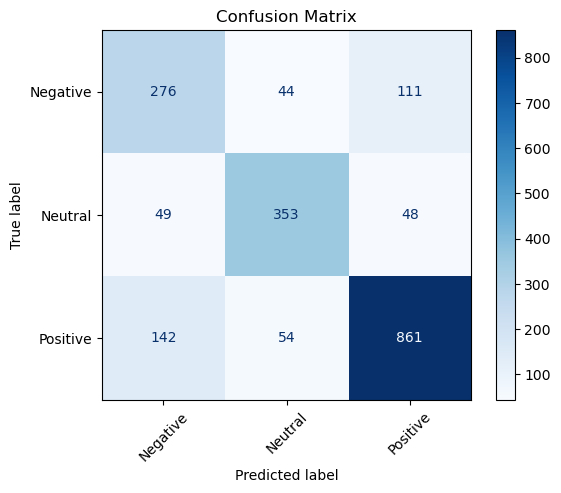

In [20]:
# Use y_test directly if it's already label-encoded (not one-hot)
cm = confusion_matrix(y_test, y_pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_lstm.png")
plt.show()


Bar chart of accuracy per class

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


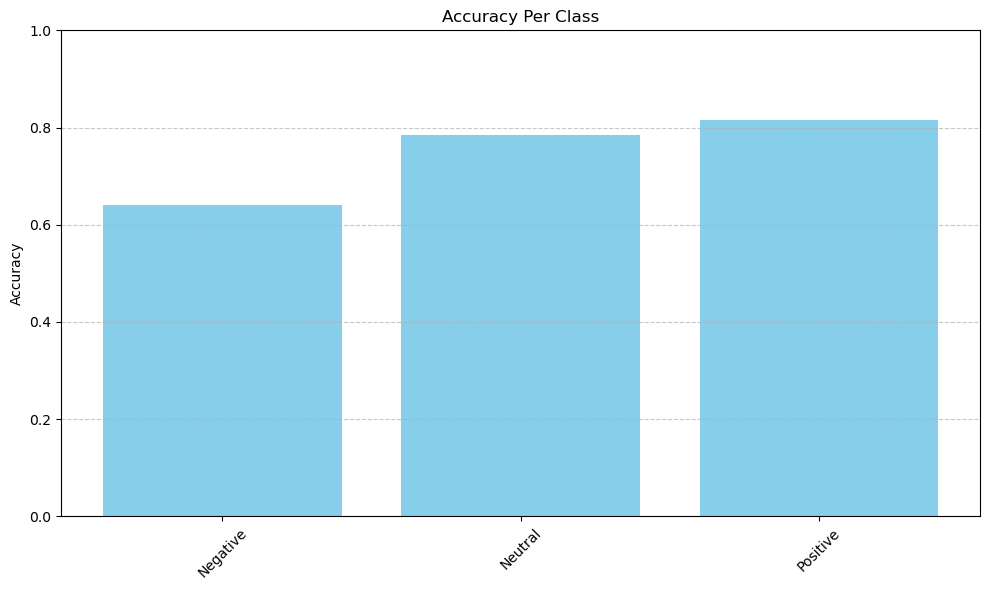

In [21]:
# Get predicted and true labels
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_true_labels = y_test

# Compute per-class accuracy
num_classes = len(np.unique(y_true_labels))
class_accuracies = []
for i in range(num_classes):
    idx = np.where(y_true_labels == i)[0]
    acc = accuracy_score(y_true_labels[idx], y_pred_labels[idx])
    class_accuracies.append(acc)

# Plot bar chart
plt.figure(figsize=(10, 6))
class_names = label_encoder.classes_  # assumes LabelEncoder was used earlier
plt.bar(class_names, class_accuracies, color='skyblue')
plt.ylabel("Accuracy")
plt.title("Accuracy Per Class")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("accuracy_per_class_lstm.png")


Classification metrics per class

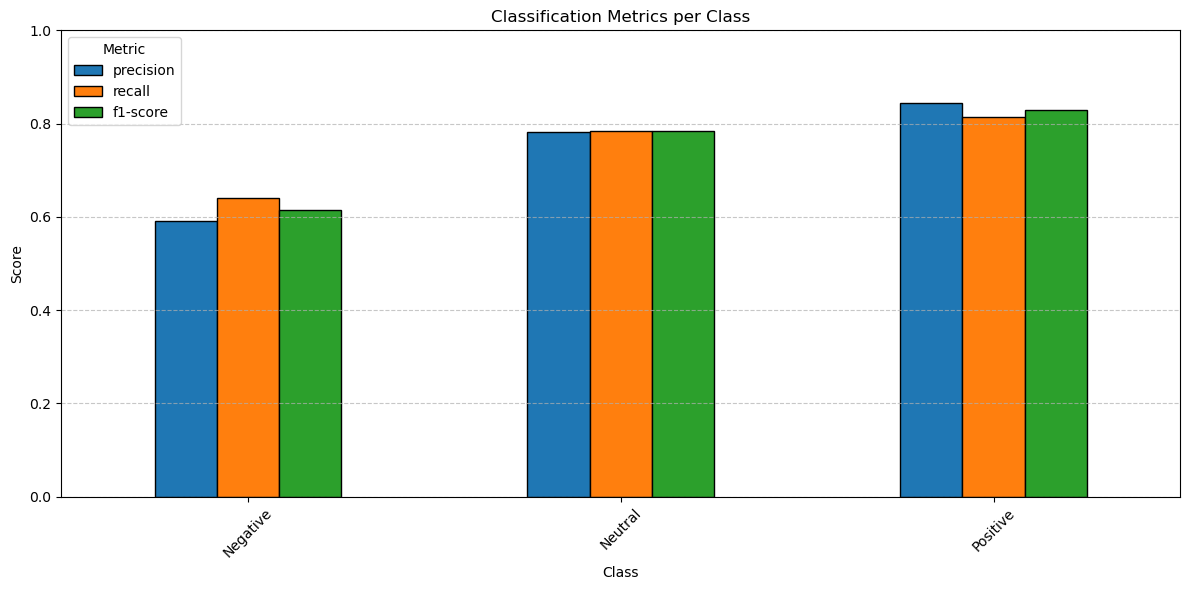

In [24]:
# Get the classification report as a dictionary
report_dict = classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Keep only class rows (exclude avg/total rows)
metrics = report_df.loc[label_encoder.classes_, ["precision", "recall", "f1-score"]]

# Plot grouped bar chart
metrics.plot(kind="bar", figsize=(12, 6), edgecolor="black")

plt.title("Classification Metrics per Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("classification_report_lstm.png")
plt.show()
